In [1]:
# Uncomment pyximport to compile instead of running pure python
#import pyximport; pyximport.install(language_level=3)

import copy
import math
import pandas
from matplotlib import pyplot as plt
from py_ballisticcalc import DragModel, TableG7, TableG1
from py_ballisticcalc import Ammo, Atmo, Wind
from py_ballisticcalc import Weapon, Shot, Calculator
from py_ballisticcalc import Settings as Set
from py_ballisticcalc.unit import *

print("Default units:\n"+str(Set.Units))  # Print default units

Default units:
angular = degree
distance = yard
velocity = fps
pressure = inHg
temperature = fahrenheit
diameter = inch
length = inch
weight = grain
adjustment = mil
drop = inch
energy = foot-pound
ogw = pound
sight_height = inch
target_height = inch
twist = inch


# Simple Zero

In [2]:
# Establish 100-yard zero for a standard .308, G7 BC=0.22, muzzle velocity 2600fps
zero = Shot(weapon=Weapon(sight_height=2), ammo=Ammo(DragModel(0.22, TableG7), mv=Velocity.FPS(2600)))
calc = Calculator()
zero_distance = Distance.Yard(100)
zero_elevation = calc.set_weapon_zero(zero, zero_distance)
print(f'Barrel elevation for {zero_distance} zero: {zero_elevation << Set.Units.adjustment}')

Barrel elevation for 100.0yd zero: 1.33mil


# Plot Trajectory with Danger Space

Danger space at 300.0yd for 19.7inch tall target ranges from 217.1yd to 355.8yd


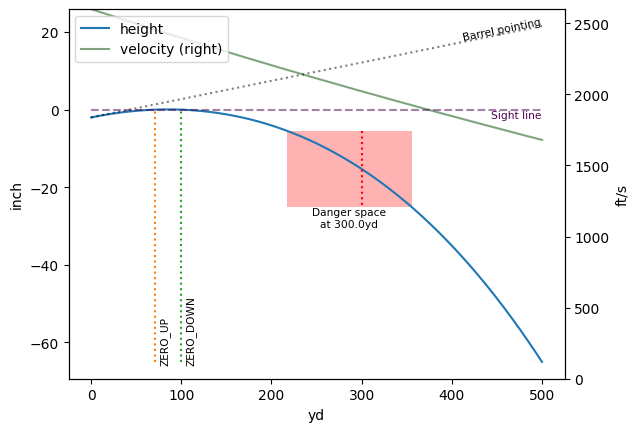

In [3]:
# Plot trajectory out to 500 yards
shot_result = calc.fire(zero, trajectory_range=500, extra_data=True)
ax = shot_result.plot()
# Find danger space for a half-meter tall target at 300 yards
danger_space = shot_result.danger_space(Distance.Yard(300), Distance.Meter(.5))
print(danger_space)
danger_space.overlay(ax)  # Highlight danger space on the plot
plt.show()

# Print Range Card

In [4]:
# Range card for this zero with 5mph cross-wind from left to right
zero.winds = [Wind(Velocity.MPH(5), Angular.OClock(3))]
range_card = calc.fire(zero, trajectory_range=1000)
# for p in range_card: print(p.formatted())
range_card.dataframe().to_clipboard()
range_card.dataframe(True).drop(['height', 'energy', 'ogw', 'flag'], axis=1)

,time,distance,velocity,mach,target_drop,drop_adj,windage,windage_adj,look_distance,angle,density_factor,drag
0,0.000 s,0.0 yd,2600.0 ft/s,2.33 mach,-2.0 inch,0.00 mil,0.0 inch,0.00 mil,0.0 yd,0.0750 °,4.548e-05,0.000
1,0.120 s,100.0 yd,2398.1 ft/s,2.15 mach,-0.0 inch,-0.00 mil,0.4 inch,0.12 mil,100.0 yd,-0.0137 °,4.548e-05,0.658
2,0.251 s,200.0 yd,2205.5 ft/s,1.98 mach,-4.1 inch,-0.57 mil,1.7 inch,0.25 mil,200.0 yd,-0.1183 °,4.548e-05,0.626
3,0.393 s,300.0 yd,2022.3 ft/s,1.81 mach,-15.3 inch,-1.44 mil,4.1 inch,0.39 mil,300.0 yd,-0.2424 °,4.548e-05,0.596
4,0.548 s,400.0 yd,1847.5 ft/s,1.65 mach,-35.0 inch,-2.48 mil,7.6 inch,0.54 mil,400.0 yd,-0.3905 °,4.548e-05,0.570
5,0.718 s,500.0 yd,1680.1 ft/s,1.50 mach,-65.0 inch,-3.68 mil,12.4 inch,0.70 mil,500.0 yd,-0.5688 °,4.548e-05,0.547
6,0.906 s,600.0 yd,1519.5 ft/s,1.36 mach,-107.3 inch,-5.06 mil,18.8 inch,0.89 mil,600.0 yd,-0.7856 °,4.548e-05,0.524
7,1.114 s,700.0 yd,1366.0 ft/s,1.22 mach,-164.8 inch,-6.66 mil,27.0 inch,1.09 mil,700.0 yd,-1.0523 °,4.548e-05,0.499
8,1.347 s,800.0 yd,1221.3 ft/s,1.09 mach,-240.9 inch,-8.52 mil,37.3 inch,1.32 mil,800.0 yd,-1.3842 °,4.548e-05,0.465
9,1.607 s,900.0 yd,1093.2 ft/s,0.98 mach,-340.5 inch,-10.71 mil,50.0 inch,1.57 mil,900.0 yd,-1.8006 °,4.548e-05,0.326


# Firing Solutions

## Different Distance, from Range Card

First approach here shows getting firing solution by looking up the adjustment in the Range Card:

In [5]:
# Now shooter is sighting a target at look-distance 500 yard (zero.look-angle):
new_target_distance = Distance.Yard(500)
# Get row for this distance from the range card
new_target = range_card.get_at_distance(new_target_distance)
print(f'Zero trajectory hits {new_target.target_drop << Set.Units.drop}'
      f' at {(new_target.distance << Set.Units.distance)}')

# Shooter looks up adjustment to hit new target:
hold = new_target.drop_adj  # << Firing solution

print(f'Sight adjustment to hit {(new_target.distance << Set.Units.distance)} target'
      f' is {(hold << Set.Units.adjustment)}')
# Shooter dials that hold value for a 500-yard shot.  Verification:
range_card.shot.relative_angle = Angular(-hold.unit_value, hold.units)
adjusted_result = calc.fire(range_card.shot, trajectory_range=1000)
trajectory_adjusted = adjusted_result.get_at_distance(new_target_distance)
print(f'After adjustment: drop at {trajectory_adjusted.distance << Set.Units.distance}'
      f' is {trajectory_adjusted.target_drop << Set.Units.drop}')

Zero trajectory hits -65.0inch at 500.0yd
Sight adjustment to hit 500.0yd target is -3.68mil
After adjustment: drop at 500.0yd is -0.0inch


## Different Look Angle

Second approach here shows solving for barrel elevation to hit new target, then adjusting by the difference between that and the zero barrel elevation:

In [6]:
# Calculate elevation for a new shot at a different look-angle
new_shot = copy.copy(zero)  # Copy the zero properties; NB: Not a deepcopy!
new_shot.look_angle = Angular.Degree(25.84)
new_elevation = calc.barrel_elevation_for_target(shot=new_shot, target_distance=new_target_distance)
# Firing solution:
hold = Angular.Mil((new_elevation >> Angular.Mil) - (zero.weapon.zero_elevation >> Angular.Mil))

print(f'To hit target at look-distance of {new_target_distance << Set.Units.distance}'
      f' sighted at a {new_shot.look_angle << Set.Units.angular} look-angle,' 
      f' barrel elevation={new_elevation << Set.Units.adjustment}')
print(f'Current zero has barrel elevated {zero.weapon.zero_elevation << Set.Units.adjustment}'
      f' so hold for new shot is {hold << Set.Units.adjustment}')      
horizontal = Distance(math.cos(new_shot.look_angle >> Angular.Radian)
                      * new_target_distance.unit_value, new_target_distance.units)
print(f'(Horizontal component of distance to this target is {horizontal})')

# Plot this shot
new_shot.relative_angle = hold
card = calc.fire(new_shot, trajectory_range=500)
card.dataframe(True).drop(['height', 'energy', 'ogw', 'flag'], axis=1)

To hit target at look-distance of 500.0yd sighted at a 25.84° look-angle, barrel elevation=4.55mil
Current zero has barrel elevated 1.33mil so hold for new shot is 3.22mil
(Horizontal component of distance to this target is 450.0yd)


,time,distance,velocity,mach,target_drop,drop_adj,windage,windage_adj,look_distance,angle,density_factor,drag
0,0.000 s,0.0 yd,2600.0 ft/s,2.33 mach,-1.8 inch,0.00 mil,0.0 inch,0.00 mil,0.0 yd,26.0961 °,4.548e-05,0.000
1,0.066 s,50.0 yd,2485.7 ft/s,2.23 mach,6.4 inch,3.23 mil,0.1 inch,0.07 mil,55.6 yd,26.0533 °,-2.144e-03,0.670
2,0.134 s,100.0 yd,2374.5 ft/s,2.13 mach,13.0 inch,3.29 mil,0.5 inch,0.15 mil,111.1 yd,26.0065 °,-4.285e-03,0.651
3,0.206 s,150.0 yd,2266.4 ft/s,2.03 mach,17.8 inch,3.02 mil,1.2 inch,0.23 mil,166.7 yd,25.9551 °,-6.416e-03,0.632
4,0.282 s,200.0 yd,2161.5 ft/s,1.94 mach,20.8 inch,2.65 mil,2.2 inch,0.31 mil,222.2 yd,25.8986 °,-8.538e-03,0.613
5,0.361 s,250.0 yd,2059.7 ft/s,1.85 mach,21.7 inch,2.21 mil,3.5 inch,0.39 mil,277.8 yd,25.8365 °,-1.065e-02,0.595
6,0.444 s,300.0 yd,1960.8 ft/s,1.76 mach,20.4 inch,1.73 mil,5.1 inch,0.48 mil,333.3 yd,25.7680 °,-1.275e-02,0.578
7,0.531 s,350.0 yd,1864.5 ft/s,1.67 mach,16.5 inch,1.20 mil,7.1 inch,0.58 mil,388.9 yd,25.6923 °,-1.484e-02,0.564
8,0.622 s,400.0 yd,1770.7 ft/s,1.59 mach,9.8 inch,0.63 mil,9.5 inch,0.67 mil,444.4 yd,25.6086 °,-1.692e-02,0.549
9,0.719 s,450.0 yd,1679.2 ft/s,1.51 mach,0.1 inch,0.01 mil,12.4 inch,0.78 mil,500.0 yd,25.5155 °,-1.898e-02,0.536


# Complex example

Now we'll switch to metric units and:
* Define a standard .50BMG
* Enable and define Ammo model of powder temperature sensitivity.
* Zeroed for a distance of 500 meters, in a 5°C atmosphere at altitude 1000ft ASL.

In [7]:
Set.Units.distance = Unit.METER
Set.Units.velocity = Unit.MPS
Set.Units.drop = Unit.METER
Set.Units.sight_height = Unit.CENTIMETER
Set.USE_POWDER_SENSITIVITY = True

# Standard .50BMG
dm = DragModel(0.62, TableG1, 661, 0.51, 2.3)
ammo=Ammo(dm, 850, Temperature.Celsius(15))
ammo.calc_powder_sens(820, Temperature.Celsius(0))
weapon = Weapon(sight_height=9, twist=15)
# Cool and windy
atmo = Atmo(altitude=Distance.Foot(1000), temperature=Unit.CELSIUS(5), humidity=.5)
zero = Shot(weapon=weapon, ammo=ammo, atmo=atmo)
zero_distance = Distance.Meter(500)
calc = Calculator()
zero_elevation = calc.set_weapon_zero(zero, zero_distance)
print(f'Barrel elevation for {zero_distance} zero: {zero_elevation << Set.Units.adjustment}')
print(f'Muzzle velocity at zero temperature {atmo.temperature} is {ammo.get_velocity_for_temp(atmo.temperature) << Set.Units.velocity}')

Barrel elevation for 500.0m zero: 4.69mil
Muzzle velocity at zero temperature 5.0°C is 830.0m/s


To hit target at look-distance of 700.0m sighted at a 30.0° look-angle, barrel elevation=6.09mil
	(horizontal distance to this target is 606.2m)
Current zero has barrel elevated 4.69mil so hold for new shot is 1.4mil
Danger space at 700.0m for 4.0m tall target at 30.0° look-angle ranges from 444.7m to 824.6m


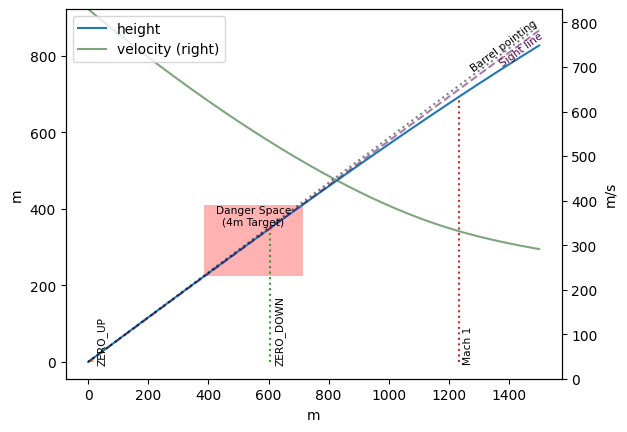

In [8]:
# Firing solution for 700m target at 30°
new_shot = copy.copy(zero)  # Copy the zero properties; NB: Not a deepcopy!
new_shot.look_angle = Angular.Degree(30)
new_target_distance = Distance.Meter(700)
new_elevation = calc.barrel_elevation_for_target(shot=new_shot, target_distance=new_target_distance)
horizontal = Distance(math.cos(new_shot.look_angle >> Angular.Radian)
                      * new_target_distance.unit_value, new_target_distance.units)
print(f'To hit target at look-distance of {new_target_distance << Set.Units.distance}'
      f' sighted at a {new_shot.look_angle << Set.Units.angular} look-angle,' 
      f' barrel elevation={new_elevation << Set.Units.adjustment}'
      f'\n\t(horizontal distance to this target is {horizontal})')

# Firing solution:
hold = Angular.Mil((new_elevation >> Angular.Mil) - (zero.weapon.zero_elevation >> Angular.Mil))
print(f'Current zero has barrel elevated {zero.weapon.zero_elevation << Set.Units.adjustment}'
      f' so hold for new shot is {hold << Set.Units.adjustment}')      

# Plot this shot
new_shot.relative_angle = hold
adjusted_result = calc.fire(new_shot, trajectory_range=1500, extra_data=True)
ax = adjusted_result.plot()
# Find danger space for a 4-meter tall target
danger_space = adjusted_result.danger_space(at_range=new_target_distance,
                                        target_height=Distance.Meter(4),
                                        look_angle=new_shot.look_angle)
print(danger_space)
# Highlight danger space on the plot
danger_space.overlay(ax, 'Danger Space\n(4m Target)')
plt.show()

## Multiple Winds

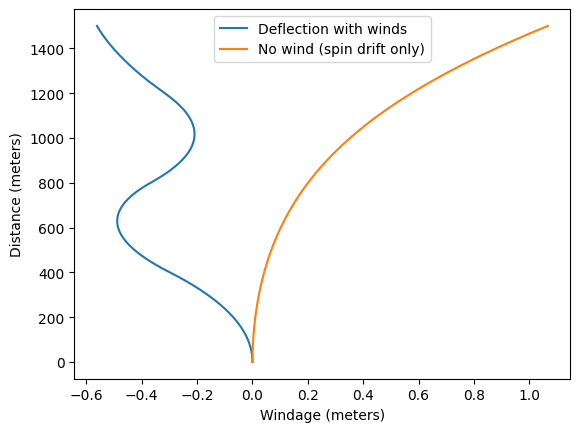

In [9]:
new_shot.winds = [Wind(Velocity.MPS(4), Angular.OClock(9), until_distance=Distance.Meter(400)),
                  Wind(Velocity.MPS(4), Angular.OClock(3), until_distance=Distance.Meter(800)),
                  Wind(Velocity.MPS(4), Angular.OClock(9), until_distance=Distance.Meter(1200)),]
wind_result = calc.fire(new_shot, trajectory_range=1500, extra_data=True)
ax = wind_result.dataframe().plot(x='windage', y='distance', ylabel=f'Distance ({Set.Units.distance.key}s)', xlabel=f'Windage ({Set.Units.distance.key}s)', label='Deflection with winds')
no_wind = adjusted_result.dataframe()
ax.plot(no_wind.windage, no_wind.distance, label='No wind (spin drift only)')
plt.legend(loc="upper center")
plt.show()

# Plot Drag Curve

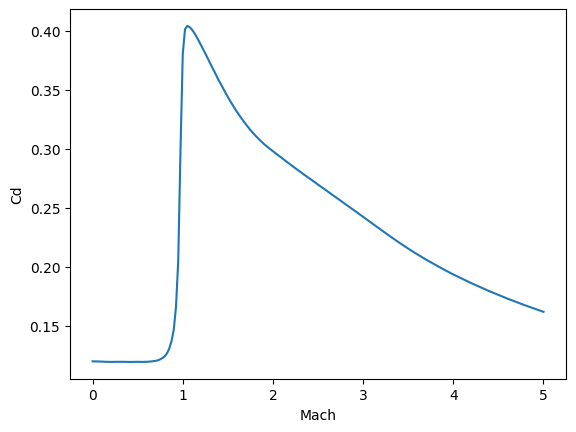

In [10]:
df = pandas.DataFrame(TableG7)
ax = df.plot(x='Mach', y='CD', ylabel='Cd', legend=False)
plt.show()

# Working With Units

In [11]:
Set.Units.distance = Unit.FOOT
print(f'Default distance unit: {Set.Units.distance.name}')
# Can create value in default unit with either float or another unit of same type
print(f'\tInstantiated from float (5): {Set.Units.distance(5)}')
print(f'\tInstantiated from Distance.Line(200): {Set.Units.distance(Distance.Line(200))}')

# Ways to define value in units
# 1. old syntax
unit_in_meter = Distance(100, Distance.Meter)
# 2. short syntax by Unit type class
unit_in_meter = Distance.Meter(100)
# 3. by Unit enum class
unit_in_meter = Unit.METER(100)
print(f'100 meters: {unit_in_meter}')
# >>> 100 meters: 100.0m

# Convert unit
# 1. by .convert()
unit_in_yards = unit_in_meter.convert(Distance.Yard)
# 2. using shift syntax
unit_in_yards = unit_in_meter << Distance.Yard  # '<<=' operator also supports
print(f'100 meters in {unit_in_yards.units.key}: {unit_in_yards}')
# >>> 100 meters in yard: 109.4yd

# Get value in specified units (as float)
# 1. by .get_in()
value_in_km = unit_in_yards.get_in(Distance.Kilometer)
# 2. by shift syntax
value_in_km = unit_in_yards >> Distance.Kilometer  # '>>=' operator also supports
print(f'100 meters, value in km: {value_in_km}  (value type is {type(value_in_km)})')
# >>> 100 meters, value in km: 0.1  (value type is <class 'float'>)

# Getting unit raw value (a float)
rvalue = Distance.Meter(100).raw_value
rvalue = float(Distance.Meter(100))
print(f'100 meters in raw value: {rvalue}  (raw type is {type(rvalue)})')
# >>> 100 meters in raw value: 3937.0078740157483  (raw type is <class 'float'>)

# Comparison operators supported: < > <= >= == !=
print(f'Comparison: {unit_in_meter} == {Distance.Centimeter(100)}: {unit_in_meter == Distance.Centimeter(100)}')  # >>> False, compare two units by raw value
print(f'Comparison: {unit_in_meter} > .1*{unit_in_meter}: {unit_in_meter > .1*unit_in_meter.raw_value}')  # >>> True, compare unit with float by raw value

Default distance unit: FOOT
	Instantiated from float (5): 5.0ft
	Instantiated from Distance.Line(200): 1.67ft
100 meters: 100.0m
100 meters in yard: 109.4yd
100 meters, value in km: 0.1  (value type is <class 'float'>)
100 meters in raw value: 3937.0078740157483  (raw type is <class 'float'>)
Comparison: 100.0m == 100.0cm: False
Comparison: 100.0m > .1*100.0m: True
